In [1]:
%cd ..

/Users/pavanpreetgandhi/git-repos/interpretable-sla


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from source.fit_predict_score_utils import fit_and_predict

In [3]:
sns.set_theme(context='paper', style='whitegrid', font_scale=1.5)

### Rubric Based Question Set

In [4]:
df = pd.read_parquet("datasets/3_rubric_based_questions.parquet")
features = df.columns[5:]
target = df.columns[3] # part_score
df[features] = np.exp(df[features])  # convert logprobs to probabilities

In [5]:
new_features = features.str[0:2] + "_" + features.str[-1]
df = df.rename(columns=dict(zip(features, new_features)))
features = new_features
print(features)

Index(['dm_A', 'dm_B', 'dm_C', 'dm_D', 'dm_E', 'dm_F', 'pf_A', 'pf_B', 'pf_C',
       'pf_D', 'pf_E', 'pf_F', 'lr_A', 'lr_B', 'lr_C', 'lr_D', 'lr_E', 'lr_F'],
      dtype='object')


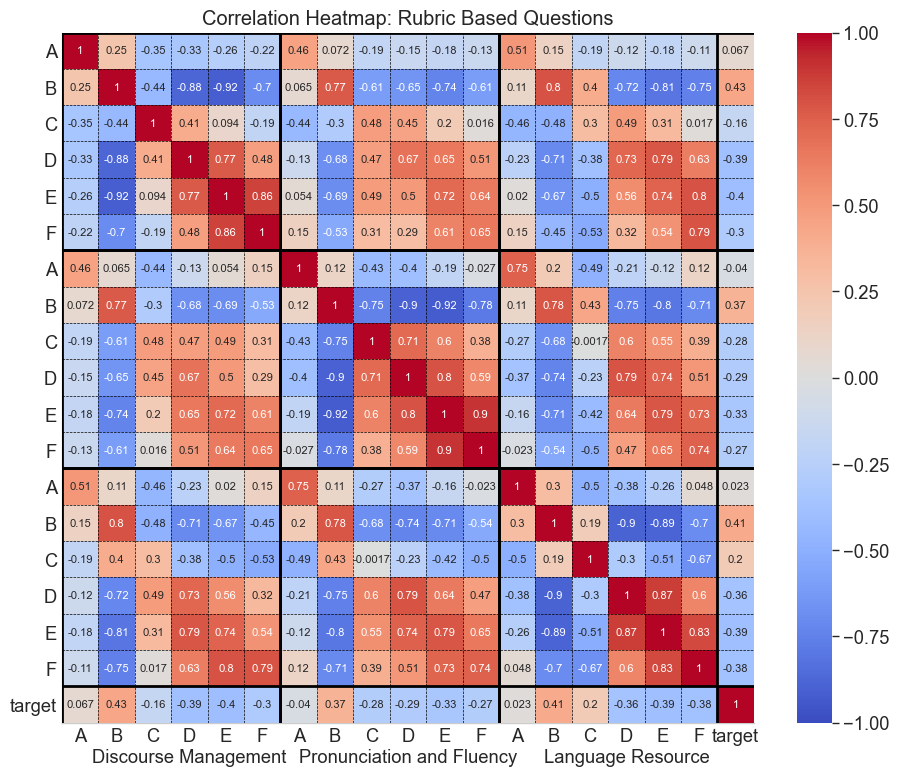

In [6]:
# Plot correlation heatmap
fig, ax = plt.subplots(figsize=(12*0.8, 10*0.8))
sns.heatmap(
    df[list(features) + [target]].corr(), 
    annot=True, 
    annot_kws={"size": 8},
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    ax=ax
)

# Add separating lines
n_options = 6
for i in range(len(features) + 1):
    ax.axhline(i, color='black', lw=0.5, linestyle='--')
    ax.axvline(i, color='black', lw=0.5, linestyle='--')
    if i % n_options == 0:
        ax.axhline(i, color='black', lw=2)
        ax.axvline(i, color='black', lw=2)

# Add category barriers for the three main categories
category_barriers = [6, 12]
for barrier in category_barriers:
    ax.axhline(barrier, color='black', lw=2)
    ax.axvline(barrier, color='black', lw=2)

ax.set_title("Correlation Heatmap: Rubric Based Questions")

# Add hierarchical x and y ticks
rotation_offset = 1
axis_offset = 10
ax.set_xticks(ticks=[3.5, 9.5, 15.5], labels=['Discourse Management', 'Pronunciation and Fluency', 'Language Resource'])
ax.set_yticks([])
ax.spines['left'].set_position(('outward', axis_offset))
ax.spines['bottom'].set_position(('outward', axis_offset))
ax.tick_params(axis='y', rotation=90)

# Secondary axes for grade labels
ax2 = ax.secondary_yaxis('left')
ax2.set_yticks(ticks=[x+0.5 for x in range(len(features)+1)], labels=['A', 'B', 'C', 'D', 'E', 'F']*3 + ['target'], rotation=0)
ax2.tick_params(length=0)

ax3 = ax.secondary_xaxis('bottom')
ax3.set_xticks(ticks=[x+0.5 for x in range(len(features)+1)], labels=['A', 'B', 'C', 'D', 'E', 'F']*3 + ['target'], rotation=0)
ax3.tick_params(length=0)

plt.tight_layout()
plt.savefig("report/images/correlation_matrix_rubric.png", dpi=300, bbox_inches='tight')

plt.show()

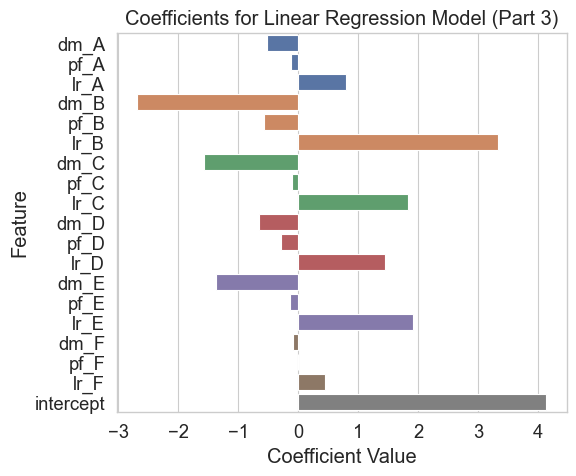

In [7]:
# NOTE: increasing alpha enough so that coefficients for high grades are +ve and low grades are -ve will result in very small coefficients and near a constant model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(alpha=0))
])
predictions, pipelines = fit_and_predict(df, features, pipeline)

part = 3
weights = pd.Series(pipelines[part].named_steps['regressor'].coef_, index=features)
weights.loc['intercept'] = pipelines[part].named_steps['regressor'].intercept_

plt.figure(figsize=(6, 5))
for grade in ['A', 'B', 'C', 'D', 'E', 'F']:
    weights_grade = weights[weights.index.str.contains(grade)]
    sns.barplot(x=weights_grade.values, y=weights_grade.index)
sns.barplot(x=[weights['intercept']], y=['intercept'], color='gray')
plt.title(f'Coefficients for Linear Regression Model (Part {part})')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')

plt.tight_layout()
plt.savefig("report/images/coefficients.png", dpi=300, bbox_inches='tight')

plt.show()

### Original Question Set

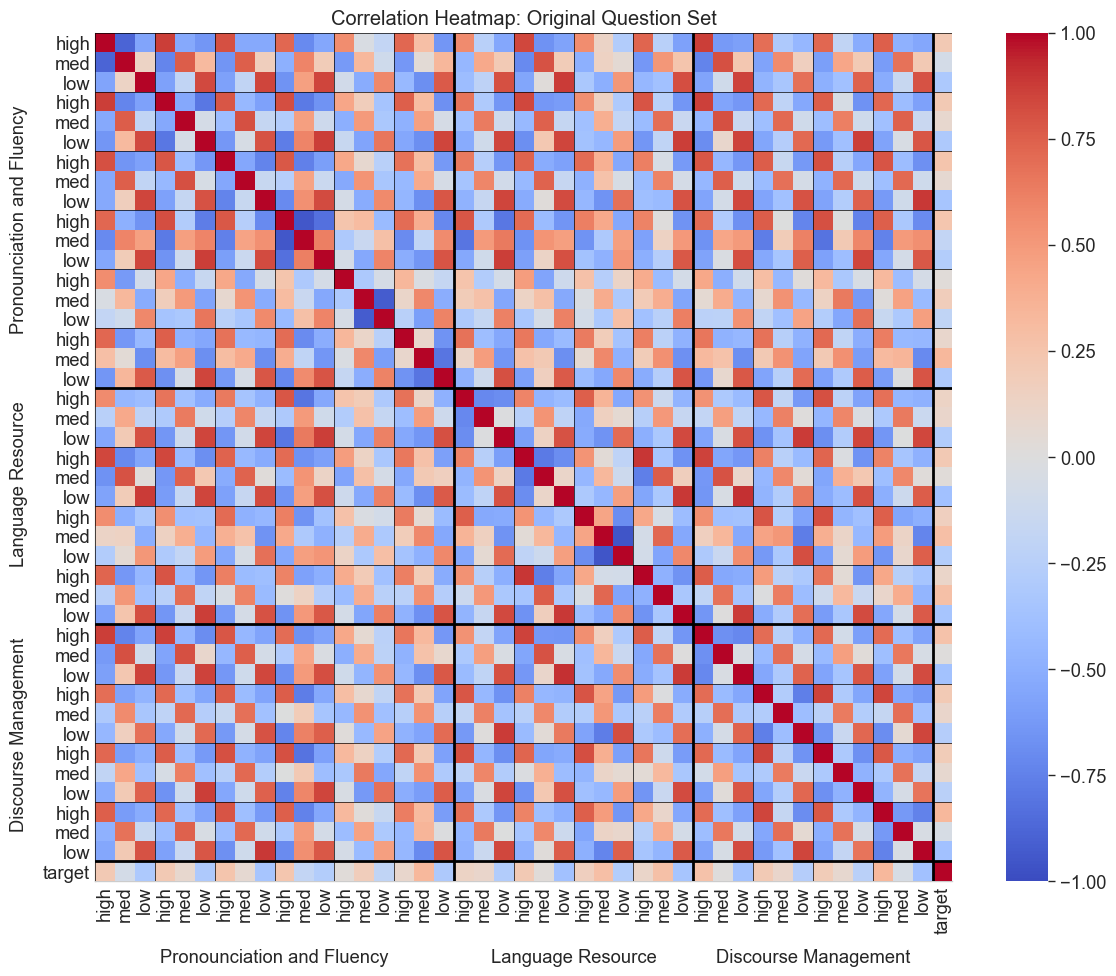

In [8]:
df = pd.read_parquet("datasets/1_original_question_set.parquet")
features = df.columns[5:]
target = df.columns[3] # part_score
df[features] = np.exp(df[features])  # convert logprobs to probabilities

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    df[list(features) + [target]].corr(), 
    # annot=True, 
    # annot_kws={"size": 8},
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    ax=ax
)

# Add separating lines
n_options = 3
for i in range(len(features) + 1):
    if i % n_options == 0:
        ax.axhline(i, color='black', lw=0.5)
        ax.axvline(i, color='black', lw=0.5)
category_barriers = [18, 30, 42]
for barrier in category_barriers:
    ax.axhline(barrier, color='black', lw=2)
    ax.axvline(barrier, color='black', lw=2)
ax.set_title("Correlation Heatmap: Original Question Set")

# Add x and y ticks
rotation_offset = 5
ax.set_xticks(ticks=[9, 24, 36], labels=['Pronounciation and Fluency', 'Language Resource', 'Discourse Management'])
ax.set_yticks(ticks=[9-rotation_offset, 24-rotation_offset, 36-rotation_offset], labels=['Pronounciation and Fluency', 'Language Resource', 'Discourse Management'])
ax.spines['left'].set_position(('outward', 40))
ax.spines['bottom'].set_position(('outward', 40))
ax.tick_params(axis='y', rotation=90)

ax2 = ax.secondary_yaxis('left')
ax2.set_yticks(ticks=[x+0.5 for x in range(len(features)+1)], labels=['high', 'med', 'low']*14 + ['target'], rotation=0)
ax2.tick_params(length=0)

ax3 = ax.secondary_xaxis('bottom')
ax3.set_xticks(ticks=[x+0.5 for x in range(len(features)+1)], labels=['high', 'med', 'low']*14 + ['target'], rotation=90)
ax3.tick_params(length=0)

plt.tight_layout()
plt.savefig("report/images/correlation_matrix_original.png", dpi=300, bbox_inches='tight')

plt.show()